<a href="https://colab.research.google.com/github/cruz-marco/dex_files/blob/main/wrang_prova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
import scipy.stats as scp 

In [ ]:
rdf = pd.read_json('/content/drive/MyDrive/Datasets/Wine_Dataset/winemag-data-130k-v2.json')

rdf.head()

,points,title,description,taster_name,taster_twitter_handle,price,designation,variety,region_1,region_2,province,country,winery
0,87,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",Kerin O’Keefe,@kerinokeefe,NaN,Vulkà Bianco,White Blend,Etna,None,Sicily & Sardinia,Italy,Nicosia
1,87,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",Roger Voss,@vossroger,15.0,Avidagos,Portuguese Red,None,None,Douro,Portugal,Quinta dos Avidagos
2,87,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",Paul Gregutt,@paulgwine,14.0,None,Pinot Gris,Willamette Valley,Willamette Valley,Oregon,US,Rainstorm
3,87,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",Alexander Peartree,None,13.0,Reserve Late Harvest,Riesling,Lake Michigan Shore,None,Michigan,US,St. Julian
4,87,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",Paul Gregutt,@paulgwine,65.0,Vintner's Reserve Wild Child Block,Pinot Noir,Willamette Valley,Willamette Valley,Oregon,US,Sweet Cheeks


In [ ]:
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   points                 129971 non-null  int64  
 1   title                  129971 non-null  object 
 2   description            129971 non-null  object 
 3   taster_name            103727 non-null  object 
 4   taster_twitter_handle  98758 non-null   object 
 5   price                  120975 non-null  float64
 6   designation            92506 non-null   object 
 7   variety                129970 non-null  object 
 8   region_1               108724 non-null  object 
 9   region_2               50511 non-null   object 
 10  province               129908 non-null  object 
 11  country                129908 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 12.9+ MB


In [ ]:
num_lines = int(rdf.shape[0])
num_columns = list(rdf.columns)

dict_cols = list()
for coluna in num_columns:
  if rdf[coluna].isna().sum() > 0:
    dict_cols.append([coluna, round((rdf[coluna].isna().sum() / num_lines), 3)])

print(*sorted(dict_cols, key=lambda x: x[1], reverse=True), sep='\n')


['region_2', 0.611]
['designation', 0.288]
['taster_twitter_handle', 0.24]
['taster_name', 0.202]
['region_1', 0.163]
['price', 0.069]
['variety', 0.0]
['province', 0.0]
['country', 0.0]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb0806cf90>,
      dtype=object)

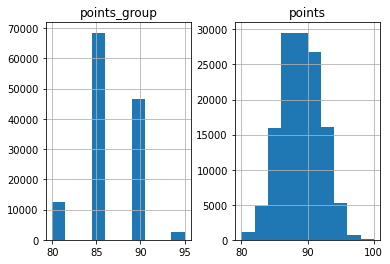

In [ ]:
train = rdf.points.dropna().values.reshape(-1,1)

discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')

discretizer.fit(train)

rdf['points_group'] = discretizer.transform(train)*5 + 80

rdf[['points_group', 'points']].hist()

In [ ]:
df_price_per_group = rdf[["country", "points_group","price"]].groupby(["country", "points_group"]).mean()

df_price_per_group

price
country   points_group           
Argentina 80.0          14.421735
          85.0          19.427708
          90.0          50.348745
          95.0          83.363636
Armenia   85.0          14.500000
...                           ...
Ukraine   80.0           9.300000
          85.0           9.000000
Uruguay   80.0          19.625000
          85.0          25.205882
          90.0          40.764706

[120 rows x 1 columns]

In [ ]:
med = rdf.price.mean()

n_rdf = rdf.merge(df_price_per_group, how='left', on=['country', 'points_group'], suffixes=['', '_per_group'])

n_rdf.price.fillna(n_rdf.price_per_group, inplace=True)

n_rdf.price.mean()

35.60524860764774

In [ ]:
s_price = pd.DataFrame()
s_price['price'] = rdf.price.dropna()
s_price['z_score'] = scp.zscore(s_price['price'], ddof=1)

s_price[abs(s_price['z_score'])>3]



,price,z_score
284,215.0,4.379008
345,350.0,7.669907
346,350.0,7.669907
347,775.0,18.030147
349,225.0,4.622778
...,...,...
129235,160.0,3.038271
129251,300.0,6.451056
129293,180.0,3.525812
129666,235.0,4.866548


In [ ]:


sev_plus_count = rdf[['country', 'title']].groupby(by='country').agg('count').sort_values('title', ascending=False)[:7].reset_index()

print(sev_plus_count.title.sum() / rdf.shape[0])
sev_plus_count

0.8982388378946072


,country,title
0,US,54504
1,France,22093
2,Italy,19540
3,Spain,6645
4,Portugal,5691
5,Chile,4472
6,Argentina,3800


In [ ]:
df_us_prov = rdf[rdf.country == 'US'][['province', 'title']].groupby('province').agg('count').sort_values('title', ascending=False).reset_index()

df_us_prov[df_us_prov['title'] >= 100]

,province,title
0,California,36247
1,Washington,8639
2,Oregon,5373
3,New York,2688
4,Virginia,777
5,Idaho,192
6,Michigan,114


(array([1.1000e+01, 4.6000e+01, 1.2000e+02, 4.3300e+02, 2.2310e+03,
        5.4970e+03, 7.4830e+03, 1.2828e+04, 1.8924e+04, 1.5409e+04,
        1.8250e+04, 1.4741e+04, 1.2360e+04, 7.9740e+03, 2.9400e+03,
        1.0770e+03, 3.9200e+02, 2.0500e+02, 4.5000e+01, 9.0000e+00]),
 array([1.13708591, 1.23379736, 1.33050881, 1.42722026, 1.52393171,
        1.62064316, 1.71735461, 1.81406606, 1.91077751, 2.00748896,
        2.10420041, 2.20091186, 2.29762331, 2.39433476, 2.4910462 ,
        2.58775765, 2.6844691 , 2.78118055, 2.877892  , 2.97460345,
        3.0713149 ]),
 <a list of 20 Patch objects>)

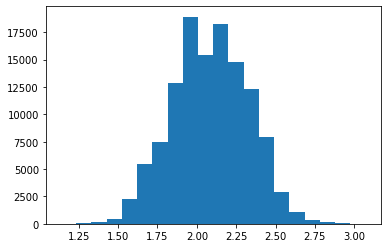

In [ ]:
b_price = pd.DataFrame()
b_price['price'] = rdf.price
b_price['box_price'] = scp.boxcox(rdf.price, lmbda=-0.296)


plt.hist(b_price.box_price, bins=20)

In [ ]:
prov_price = rdf[['province', 'price']].groupby('province').agg('mean')

df_prov_price = rdf.merge(prov_price, how='left', on=['province'], suffixes=('','_mean')).head()
df_prov_price['p_diference'] = df_prov_price['price'] - df_prov_price['price_mean']

df_prov_price[['price', 'price_mean', 'p_diference']].head()

,price,price_mean,p_diference
0,NaN,27.623477,NaN
1,15.0,29.141975,-14.141975
2,14.0,36.545064,-22.545064
3,13.0,32.432432,-19.432432
4,65.0,36.545064,28.454936
